In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import linregress

In [2]:
def parseHdr(hdrraw):
    hdr=dict()
    hdr['Serialnumber']=hdrraw[2:4].view(np.uint32)[0]
    hdr['Optics']=hdrraw[16]
    hdr['TempMinRange']=int((hdrraw[17]-1000)/10)
    hdr['TempMaxRange']=int((hdrraw[18]-1000)/10)
    hdr['TempMaxRangeStr']=str(hdr['TempMaxRange']).replace('-','M')
    hdr['TempMinRangeStr']=str(hdr['TempMinRange']).replace('-','M')
    return hdr

In [3]:
def readCalib(calibDir,hdr):
    calibFile = 'Kennlinie-{}-{}-{}-{}.prn'.format(
    hdr['Serialnumber'],
    hdr['Optics'],
    hdr['TempMinRangeStr'],
    hdr['TempMaxRangeStr'])
    # we need fixed width format read to handle this: -1759-0.08643995894)
    dfcali = pd.read_fwf(
        os.path.join(calibDir,calibFile), header=None, widths=[14,1000], names=['data','temp'])
    return dfcali, calibFile

In [4]:
# https://stackoverflow.com/questions/67340899/extracting-temperatures-from-ravi-file-in-matlab/67356437#67356437?s=a6850d00e741402aab9b33788455a36f
def readRavi(raviFilename, endFrame):
    cap = cv2.VideoCapture(raviFilename)  # Opens a video file for capturing

    # Fetch undecoded RAW video streams
    cap.set(cv2.CAP_PROP_FORMAT, -1)  # Format of the Mat objects. Set value -1 to fetch undecoded RAW video streams (as Mat 8UC1). [Using cap.set(cv2.CAP_PROP_CONVERT_RGB, 0) is not working]

    cols  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Get video frames width
    rows = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Get video frames height
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Get video frames count

    n = min(endFrame,frames)
    video = np.zeros((rows-1,cols,n))

    for k in range(0,n):
        ret, frame = cap.read()  # Read next video frame (undecoded frame is read as long row vector).

        if not ret:
            break  # Stop reading frames when ret = False (after the last frame is read).

        # View frame as int16 elements, and reshape to cols x rows (each pixel is signed 16 bits)
        frame = frame.view(np.int16).reshape(rows, cols)

        video[:,:,k] = frame[1:, :]  # Ignore the first row.

    cap.release()
    # read hdr outside the loop as it is repeated before each frame
    hdrraw = frame[0, :]
    hdr = parseHdr(hdrraw)

    return hdr, video

In [5]:
calibDir='aux/'
testdata = dict()
testdata[0] = dict(
    raviFilename='ravi/Pic_Snap_2022-02-16_11-42-39.ravi',
    refFrameIdx = 0, 
    refFrameFilename='frames/Video_Pic_Frame_1.csv')
testdata[1] = dict(
    raviFilename='ravi/Pic_Snap_2022-02-16_11-42-39.ravi',
    refFrameIdx = 1, 
    refFrameFilename='frames/Video_Pic_Frame_2.csv')
testdata[2] = dict(
    raviFilename='ravi/Snapshot_2021-01-28_09-06-23.ravi',
    refFrameIdx = 0, 
    refFrameFilename='frames/Video2_Pic_Frame_1.csv')
testdata[3] = dict(
    raviFilename='ravi/Snapshot_2021-01-28_09-06-23.ravi',
    refFrameIdx = 1, 
    refFrameFilename='frames/Video2_Pic_Frame_2.csv')

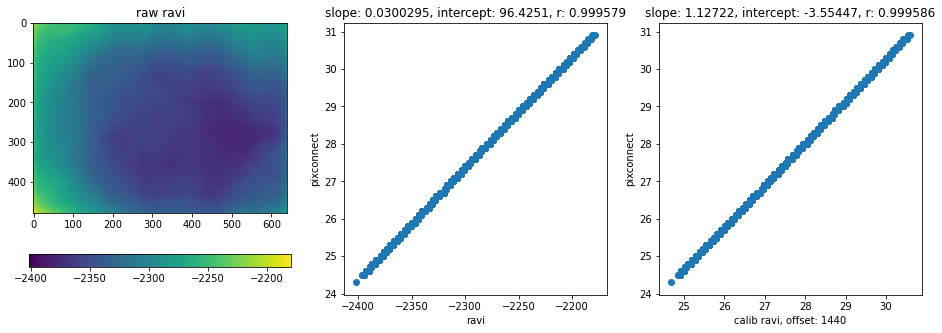

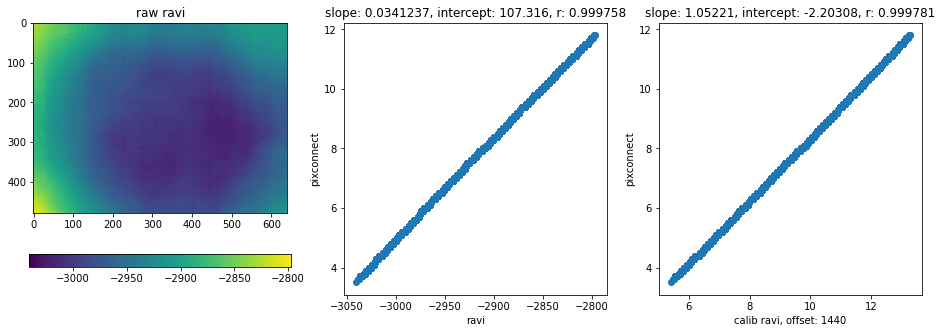

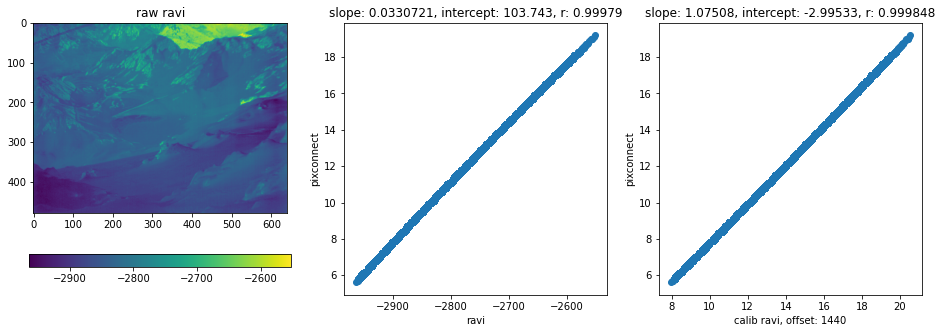

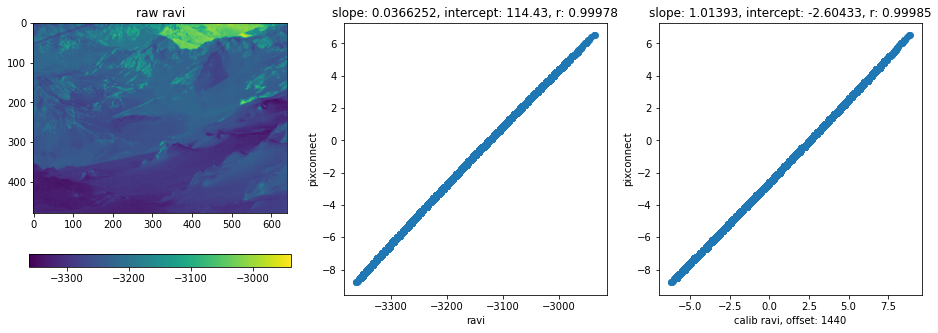

In [6]:
# test if a cst offset could be used.. answer is no
caliOffset = 1440

for i in range(0,4):
    raviFilename = testdata[i]['raviFilename']
    refFrameIdx = testdata[i]['refFrameIdx']
    refFrameFilename = testdata[i]['refFrameFilename']
    hdr, video = readRavi(raviFilename, refFrameIdx+1)
    dfcali, calibFile = readCalib(calibDir,hdr)
    frame_ravi = video[:,:,refFrameIdx]
    
    fig, ax = plt.subplots(1, 3, figsize=(16, 5))

    im = ax[0].imshow(frame_ravi)
    plt.colorbar(im, ax=ax[0], orientation='horizontal')
    ax[0].set_title('raw ravi')

    
    # read frame exported from pixconnect
    frame_pix = pd.read_csv(refFrameFilename, delimiter=';', header=None)
    # remove last (empty) column
    frame_pix.drop(frame_pix.columns[-1], axis=1, inplace=True)

    x = frame_ravi.flatten()
    y = frame_pix.values.flatten()
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    s = "slope: {:g}, intercept: {:g}, r: {:g}".format(slope, intercept, r_value)
    ax[1].scatter(x,y)
    xmi = x.min()
    xma = x.max()
    ymi = y.min()
    yma = y.max()
    ax[1].set_xlabel('ravi')
    ax[1].set_ylabel('pixconnect')
    ax[1].set_title(s)

    # what should we do with this? 
    # http://documentation.evocortex.com/libirimager2/html/index.html#:~:text=%E2%9C%85-,Video%20format,-The%20PI%20imagers
    frame_ravi_temp = np.interp(frame_ravi + caliOffset, dfcali.data, dfcali.temp)

    x = frame_ravi_temp.flatten()
    y = frame_pix.values.flatten()
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    s = "slope: {:g}, intercept: {:g}, r: {:g}".format(slope, intercept, r_value)
    ax[2].scatter(x,y)
    mi = min(x.min(),y.min())
    ma = max(x.max(),y.max())
    ax[2].set_xlabel('calib ravi, offset: {:g}'.format(caliOffset))
    ax[2].set_ylabel('pixconnect')
    ax[2].set_title(s);


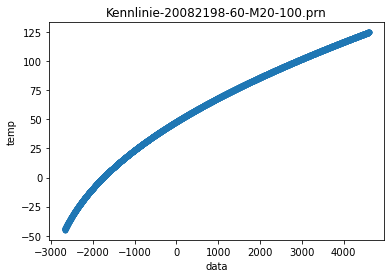

In [7]:
dfcali.plot.scatter(x='data',y='temp')
plt.title(calibFile);

In [8]:
def readRaviRow1(raviFilename, endFrame):
    cap = cv2.VideoCapture(raviFilename)  # Opens a video file for capturing

    # Fetch undecoded RAW video streams
    cap.set(cv2.CAP_PROP_FORMAT, -1)  # Format of the Mat objects. Set value -1 to fetch undecoded RAW video streams (as Mat 8UC1). [Using cap.set(cv2.CAP_PROP_CONVERT_RGB, 0) is not working]

    cols  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Get video frames width
    rows = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Get video frames height
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Get video frames count

    n = min(endFrame,frames)
    row1 = np.zeros((n,cols))

    for k in range(0,n):
        ret, frame = cap.read()  # Read next video frame (undecoded frame is read as long row vector).

        if not ret:
            break  # Stop reading frames when ret = False (after the last frame is read).

        # View frame as int16 elements, and reshape to cols x rows (each pixel is signed 16 bits)
        frame = frame.view(np.int16).reshape(rows, cols)

        row1[k,:] = frame[0, :]  # Store only the first row.

    cap.release()
    
    return row1

In [9]:
# extract the first row of the 5 first frames 
n = 5 
row1 = readRaviRow1(raviFilename, n)
# and print the 60 first fields (only zeros or one after that)
pd.DataFrame(row1[:,:60].transpose(), 
             columns=['frame{}'.format(i) for i in range(n)], # frame number
             index = range(1,61)) # matlab indexing 

,frame0,frame1,frame2,frame3,frame4
1,128.0,128.0,128.0,128.0,128.0
2,1013.0,1013.0,1013.0,1013.0,1013.0
3,28182.0,28182.0,28182.0,28182.0,28182.0
4,306.0,306.0,306.0,306.0,306.0
5,640.0,640.0,640.0,640.0,640.0
6,480.0,480.0,480.0,480.0,480.0
7,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0
9,2923.0,2923.0,2921.0,2921.0,2920.0
10,3797.0,3797.0,3797.0,3797.0,3797.0
